# Parsing ChEMBL Antibiotic Activity Data

## Importing Libraries

In [1]:
%load_ext autoreload
%autoreload 2
    
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdPartialCharges
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import rdMolAlign
from rdkit.Chem import PeriodicTable
from rdkit.Chem import rdEHTTools
from rdkit.Chem import Descriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import Crippen
from rdkit.Chem import Descriptors3D

from tqdm import tqdm as tq

import math
from scipy import stats

import embeddingMethods.embedding_3d as e3

## Defining Functions

### ChEMBL Input Functions

In [2]:
def flatten(xss):
    return [x for xs in xss for x in xs]

def ChEMBL_to_MLInput(in_df):
    params = AllChem.ETKDGv3()
    params.randomSeed = 0xf00d # optional random seed for reproducibility
    unique_mol_SMILES = [] #List of Smiles for each unique molecule
    all_GPactivities = [] #List of lists all GP activities
    all_GNactivities = [] #List of lists all GN activities

    #Drug Like Parameters
    molecular_weights = []
    molecular_log1p = []
    molecular_spherocity_index = []
    
    
    duplicate_count = 0

    skipped_moleucle_log = []

    #Organizing Data=====
    print('Sorting data. . .')
    for i in tq(range(len(in_df))):
        #Converting SMILE to rdkit obj-----
        try:
            if str(in_df.loc[i, 'Smiles']) == 'nan':
                skipped_moleucle_log.append(i)
                continue
                
            else:
                rdkit_mol = Chem.MolFromSmiles(str(in_df.loc[i, 'Smiles']))
                created_smile = Chem.MolToSmiles(Chem.AddHs(rdkit_mol)) #Remaking smiles for standerdized format with explicit Hydrogens
            
        except:
            skipped_moleucle_log.append(i)
            continue

        #Performing Unit Conversion-----
        if in_df.loc[i, 'Standard Units'] == 'ug.mL-1':
            MIC = float(in_df.loc[i, 'Value'])*(1000/Chem.Descriptors.ExactMolWt(rdkit_mol)) #Converting MIC to uM
        else:
            MIC = float(in_df.loc[i, 'Value'])
        
        #Organizing data into dictionary-----
        if created_smile not in unique_mol_SMILES: #If unique molecule
            unique_mol_SMILES.append(created_smile)
            
            rdkit_mol = Chem.AddHs(rdkit_mol)
            molecular_weights.append(Descriptors.ExactMolWt(rdkit_mol))
            molecular_log1p.append(Crippen.MolLogP(rdkit_mol))

            
            if in_df.loc[i, 'Target Organism'] in organisms['GP']: #If Gram Positive Organism
                all_GPactivities.append([MIC])
                all_GNactivities.append([])
                
            elif in_df.loc[i, 'Target Organism'] in organisms['GN']: #If Gram Negative Organism
                all_GPactivities.append([])
                all_GNactivities.append([MIC])

        else: #If not unique molecule (duplicated molecule)
            duplicate_count += 1
            p = unique_mol_SMILES.index(created_smile)

            if in_df.loc[i, 'Target Organism'] in organisms['GP']: #If Gram Positive Organism
                all_GPactivities[p].append(MIC)

            elif in_df.loc[i, 'Target Organism'] in organisms['GN']: #If Gram Negative Organism
                all_GNactivities[p].append(MIC)

    #Calculating Summary=====
    print('Calculating summary statistics. . .')
    #Mean MICs
    unique_mol_GPactivities = []
    unique_mol_GNactivities = []
    #MIC standard deviations
    unique_mol_GPstd = []
    unique_mol_GNstd = []
    #Number of repeat measurements
    unique_mol_GPn = []
    unique_mol_GNn = []
    
    for unique_mol_idx in tq(range(len(unique_mol_SMILES))):
        #Activites
        unique_mol_GPactivities.append(np.mean(all_GPactivities[unique_mol_idx]))
        unique_mol_GNactivities.append(np.mean(all_GNactivities[unique_mol_idx]))

        #Standard deviations
        unique_mol_GPstd.append(np.std(all_GPactivities[unique_mol_idx]))
        unique_mol_GNstd.append(np.std(all_GNactivities[unique_mol_idx]))

        #Measurements
        unique_mol_GPn.append(len(all_GPactivities[unique_mol_idx]))
        unique_mol_GNn.append(len(all_GNactivities[unique_mol_idx]))
        
        

    #Constructing dataframe=====
    out_dict = {'SMILES':unique_mol_SMILES,
                'GP Activity':unique_mol_GPactivities,
                'GN Activity':unique_mol_GNactivities,
                'GP stdev':unique_mol_GPstd,
                'GN stdev':unique_mol_GNstd,
                'GP n':unique_mol_GPn,
                'GN n':unique_mol_GNn,
                'Molecular Weight':molecular_weights,
                'Log1P':molecular_log1p
               }
    out_df = pd.DataFrame(out_dict)

    return out_df, duplicate_count, skipped_moleucle_log


# Polynomial Regression
def polyfit(x, y, degree):
    results = {}

    coeffs = np.polyfit(x, y, degree)

     # Polynomial Coefficients
    results['polynomial'] = coeffs.tolist()

    # r-squared
    p = np.poly1d(coeffs)
    # fit values, and mean
    yhat = p(x)                         # or [p(z) for z in x]
    ybar = np.sum(y)/len(y)          # or sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    results['determination'] = ssreg / sstot

    return results

## Importing Data and Setting Constants

In [3]:
organisms = {
    'GP':['Staphylococcus aureus', 
          'Enterococcus faecalis', 
          'Bacillus subtilis',
          'Bacillus cereus',
          'Pseudomonas fluorescens',
          'Staphylococcus epidermidis'],
    'GN':['Pseudomonas aeruginosa', 
          'Acinetobacter baumannii', 
          'Escherichia coli', 
          'klebsiella pneumoniae ottaviani',
          'Salmonella enterica',
          'Salmonella enterica subsp. enterica',
          'Salmonella enterica subsp. enterica serovar Abony',
          'Salmonella enterica subsp. enterica serovar Enteritidis',
          'Salmonella enterica subsp. enterica serovar Gallinarum',
          'Salmonella enterica subsp. enterica serovar Newport',
          'Salmonella enterica subsp. enterica serovar Paratyphi A',
          'Salmonella enterica subsp. enterica serovar Paratyphi B',
          'Salmonella enterica subsp. enterica serovar Typhi',
          'Salmonella enterica subsp. enterica serovar Typhi str. Ty2',
          'Salmonella enterica subsp. enterica serovar Typhimurium',
          'Salmonella enterica subsp. enterica serovar Typhimurium str. LT2',
          'Proteus vulgaris']
}


antibiotic_activity_cutoffs = {'MIC (uM)':[100,200], 'rZOI (mm)':[0,1]} #Cut-off values for determinign antibiotic activity ([cutoff between high and moderate activity, cutoff between moderate and no activity])
activity_hml_value = [1.5,1,0] #Value to represent high-activity, mid-activiy, and low activity

In [6]:
ChEMBL_Dir = r'../ChEMBL_dataset/ChEMBL_022025.csv'
df = pd.read_csv(ChEMBL_Dir, sep = ";", on_bad_lines='skip')

IndoleDatabase_Dir = r'../active_database/Database_v4_2.xlsx'
Indole_dataset = e3.dataset(IndoleDatabase_Dir) #Parsing Database (using new database parsing function 4/4/25)
Indole_smiles = [Chem.MolToSmiles(Chem.AddHs(i.rdkit_mol)) for i in Indole_dataset.compounds]

/tmp/ipykernel_2149865/2853080132.py:2: DtypeWarning: Columns (30,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ChEMBL_Dir, sep = ";", on_bad_lines='skip')


Experimental Values


89it [00:00, 6634.91it/s]


Litrature Indole (Benz) Values


142it [00:00, 3327.25it/s]


Litrature Quinilones


14it [00:00, 2586.34it/s]


## Cleaning Data

### Averaging and sorting duplicates

In [8]:
df = df[['Smiles', 'Target Organism', 'Value', 'Standard Units']]
df['Standard Units'] = df['Standard Units'].astype(str)
df = df[df['Target Organism'].isin(flatten(list(organisms.values())))]

df = df[df['Standard Units'].isin(['ug.mL-1','nM'])]
df.index = range(len(df))
df.loc[df['Standard Units'] == 'nM', 'Value'] *= 0.001
df['Standard Units'] = df['Standard Units'].replace('nM', 'uM')

/tmp/ipykernel_2149865/2551872124.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Standard Units'] = df['Standard Units'].astype(str)


In [9]:
sorted_df, _, _ = ChEMBL_to_MLInput(df)

Sorting data. . .


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 359716/359716 [04:52<00:00, 1228.69it/s]


Calculating summary statistics. . .


  0%|                                                                                                                                                                                 | 0/66488 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.11/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.11/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/conda/lib/python3.11/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value

### Removing duplicate indoles

In [10]:
sorted_df_removed_db_indoles = sorted_df[~sorted_df.SMILES.isin(Indole_smiles)]
sorted_df_removed_db_indoles

,SMILES,GP Activity,GN Activity,GP stdev,GN stdev,GP n,GN n,Molecular Weight,Log1P
0,[H]c1c([H])c([H])c(N([H])[H])c(C(=O)N([H])N([H...,78.093927,39.046963,0.000000,0.000000,1,1,320.127326,2.13430
1,[H]c1c([H])c(C([H])([H])n2c(C3([H])C([H])([H])...,0.010286,0.015250,0.002711,0.005629,7,4,471.195651,4.70000
2,[H]OC(=O)[C@]([H])(OC([H])([H])C([H])([H])C([H...,6.497660,11.549342,3.749648,0.000000,12,2,1082.312730,4.58590
3,[H]ON(C([H])=O)C([H])([H])C1([H])C(=O)N([H])[C...,0.004000,0.032000,0.000000,0.000000,1,1,369.262757,2.23170
4,[H]N=C(N([H])[H])N([H])C([H])([H])C([H])([H])C...,NaN,199.010041,NaN,315.022991,0,66,446.243024,2.09637
...,...,...,...,...,...,...,...,...,...
66483,O=S(=O)([O-])C(F)(F)F.[H]c1c([H])c([H])c2c(c1[...,60.482727,NaN,0.000000,NaN,1,0,529.076670,1.54940
66484,[H]c1nc(N([H])C(=O)C([H])([H])c2sc([H])c([H])c...,NaN,1168.700914,NaN,0.000000,0,1,219.046633,1.71930
66485,[H]c1c([H])c([H])c(N([H])c2nc(N([H])c3c([H])c(...,0.032000,NaN,0.000000,NaN,1,0,312.137497,5.11700
66486,[H]Oc1c([H])c([H])c([C@@]2([H])C([H])([H])C(C(...,6.170593,NaN,0.000000,NaN,1,0,648.235933,8.26420


In [11]:
sorted_df_removed_db_indoles.to_csv('../ChEMBL_dataset/ChEMBL_cleaned_040425.csv', index=False)

### Marking molecules with indole substructure

In [49]:
indole_mol = Chem.AddHs(Chem.MolFromSmiles("C1=CC=C2C(=C1)C=CN2"))

has_indole_substructure = []
for mol in tq(sorted_df_removed_db_indoles.SMILES):
    rd_mol = Chem.AddHs(Chem.MolFromSmiles(mol))
    has_indole_substructure.append(rd_mol.HasSubstructMatch(indole_mol))
    

sorted_df_removed_db_indoles['Has Indole Substructure'] = has_indole_substructure

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66455/66455 [00:22<00:00, 2899.96it/s]
/tmp/ipykernel_1676908/3247301081.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sorted_df_removed_db_indoles['Has Indole Substructure'] = has_indole_substructure


In [50]:
sorted_df_removed_db_indoles

,SMILES,GP Activity,GN Activity,GP stdev,GN stdev,GP n,GN n,Molecular Weight,Log1P,Has Indole Substructure
0,[H]c1c([H])c([H])c(N([H])[H])c(C(=O)N([H])N([H...,78.093927,39.046963,0.000000,0.000000,1,1,320.127326,2.13430,False
1,[H]c1c([H])c(C([H])([H])n2c(C3([H])C([H])([H])...,0.010286,0.015250,0.002711,0.005629,7,4,471.195651,4.70000,False
2,[H]OC(=O)[C@]([H])(OC([H])([H])C([H])([H])C([H...,6.497660,11.549342,3.749648,0.000000,12,2,1082.312730,4.58590,False
3,[H]ON(C([H])=O)C([H])([H])C1([H])C(=O)N([H])[C...,0.004000,0.032000,0.000000,0.000000,1,1,369.262757,2.23170,False
4,[H]N=C(N([H])[H])N([H])C([H])([H])C([H])([H])C...,NaN,199.010041,NaN,315.022991,0,66,446.243024,2.09637,False
...,...,...,...,...,...,...,...,...,...,...
66483,O=S(=O)([O-])C(F)(F)F.[H]c1c([H])c([H])c2c(c1[...,60.482727,NaN,0.000000,NaN,1,0,529.076670,1.54940,False
66484,[H]c1nc(N([H])C(=O)C([H])([H])c2sc([H])c([H])c...,NaN,1168.700914,NaN,0.000000,0,1,219.046633,1.71930,False
66485,[H]c1c([H])c([H])c(N([H])c2nc(N([H])c3c([H])c(...,0.032000,NaN,0.000000,NaN,1,0,312.137497,5.11700,False
66486,[H]Oc1c([H])c([H])c([C@@]2([H])C([H])([H])C(C(...,6.170593,NaN,0.000000,NaN,1,0,648.235933,8.26420,False


In [53]:
ChEMBL_indole_df = sorted_df_removed_db_indoles[sorted_df_removed_db_indoles['Has Indole Substructure']]
sorted_df_removed_db_indoles['Has Indole Substructure'].unique

<bound method Series.unique of 0        False
1        False
2        False
3        False
4        False
         ...  
66483    False
66484    False
66485    False
66486    False
66487    False
Name: Has Indole Substructure, Length: 66455, dtype: bool>

## Calculating and Plotting ChEMBL Summary Statistics

### Calculating GP/GN Linear Regression 

In [54]:
sorted_df = sorted_df_removed_db_indoles
sorted_df

,SMILES,GP Activity,GN Activity,GP stdev,GN stdev,GP n,GN n,Molecular Weight,Log1P,Has Indole Substructure
0,[H]c1c([H])c([H])c(N([H])[H])c(C(=O)N([H])N([H...,78.093927,39.046963,0.000000,0.000000,1,1,320.127326,2.13430,False
1,[H]c1c([H])c(C([H])([H])n2c(C3([H])C([H])([H])...,0.010286,0.015250,0.002711,0.005629,7,4,471.195651,4.70000,False
2,[H]OC(=O)[C@]([H])(OC([H])([H])C([H])([H])C([H...,6.497660,11.549342,3.749648,0.000000,12,2,1082.312730,4.58590,False
3,[H]ON(C([H])=O)C([H])([H])C1([H])C(=O)N([H])[C...,0.004000,0.032000,0.000000,0.000000,1,1,369.262757,2.23170,False
4,[H]N=C(N([H])[H])N([H])C([H])([H])C([H])([H])C...,NaN,199.010041,NaN,315.022991,0,66,446.243024,2.09637,False
...,...,...,...,...,...,...,...,...,...,...
66483,O=S(=O)([O-])C(F)(F)F.[H]c1c([H])c([H])c2c(c1[...,60.482727,NaN,0.000000,NaN,1,0,529.076670,1.54940,False
66484,[H]c1nc(N([H])C(=O)C([H])([H])c2sc([H])c([H])c...,NaN,1168.700914,NaN,0.000000,0,1,219.046633,1.71930,False
66485,[H]c1c([H])c([H])c(N([H])c2nc(N([H])c3c([H])c(...,0.032000,NaN,0.000000,NaN,1,0,312.137497,5.11700,False
66486,[H]Oc1c([H])c([H])c([C@@]2([H])C([H])([H])C(C(...,6.170593,NaN,0.000000,NaN,1,0,648.235933,8.26420,False


In [56]:
dual_measured_df = sorted_df[sorted_df[['GP Activity', 'GN Activity']].notnull().all(1)]
dual_measured_df = dual_measured_df[dual_measured_df['GP Activity']!= 0]
dual_measured_df = dual_measured_df[dual_measured_df['GN Activity']!= 0]
dual_measured_df

,SMILES,GP Activity,GN Activity,GP stdev,GN stdev,GP n,GN n,Molecular Weight,Log1P,Has Indole Substructure
0,[H]c1c([H])c([H])c(N([H])[H])c(C(=O)N([H])N([H...,78.093927,39.046963,0.000000,0.000000,1,1,320.127326,2.13430,False
1,[H]c1c([H])c(C([H])([H])n2c(C3([H])C([H])([H])...,0.010286,0.015250,0.002711,0.005629,7,4,471.195651,4.70000,False
2,[H]OC(=O)[C@]([H])(OC([H])([H])C([H])([H])C([H...,6.497660,11.549342,3.749648,0.000000,12,2,1082.312730,4.58590,False
3,[H]ON(C([H])=O)C([H])([H])C1([H])C(=O)N([H])[C...,0.004000,0.032000,0.000000,0.000000,1,1,369.262757,2.23170,False
5,[H]c1sc(N([H])[H])nc1/C(=N/OC([H])([H])[H])C(=...,8.770410,47.080047,6.821430,51.437639,2,4,513.088909,-1.05130,False
...,...,...,...,...,...,...,...,...,...,...
66449,[H]c1nc(-c2nc3c([H])c([H])c(C([H])([H])[H])c([...,478.250832,239.125416,0.000000,0.000000,1,1,209.095297,2.93332,False
66450,[H]/C(C(=O)c1c([H])c([H])c(Br)c([H])c1[H])=C(/...,298.366433,298.366433,0.000000,0.000000,1,1,418.947931,6.50862,False
66453,[H]N=C(N([H])[H])N([H])C([H])([H])C([H])([H])C...,0.010000,0.010000,0.000000,0.000000,1,1,3138.367616,-12.95283,False
66454,[H]Oc1c([H])c(O[H])c(C([H])(C([H])([H])[H])C([...,0.300000,0.037500,0.000000,0.000000,1,1,465.226371,4.12510,False


Text(0, 0.5, 'Gram-Negative MIC $log_{10}(uM)$')

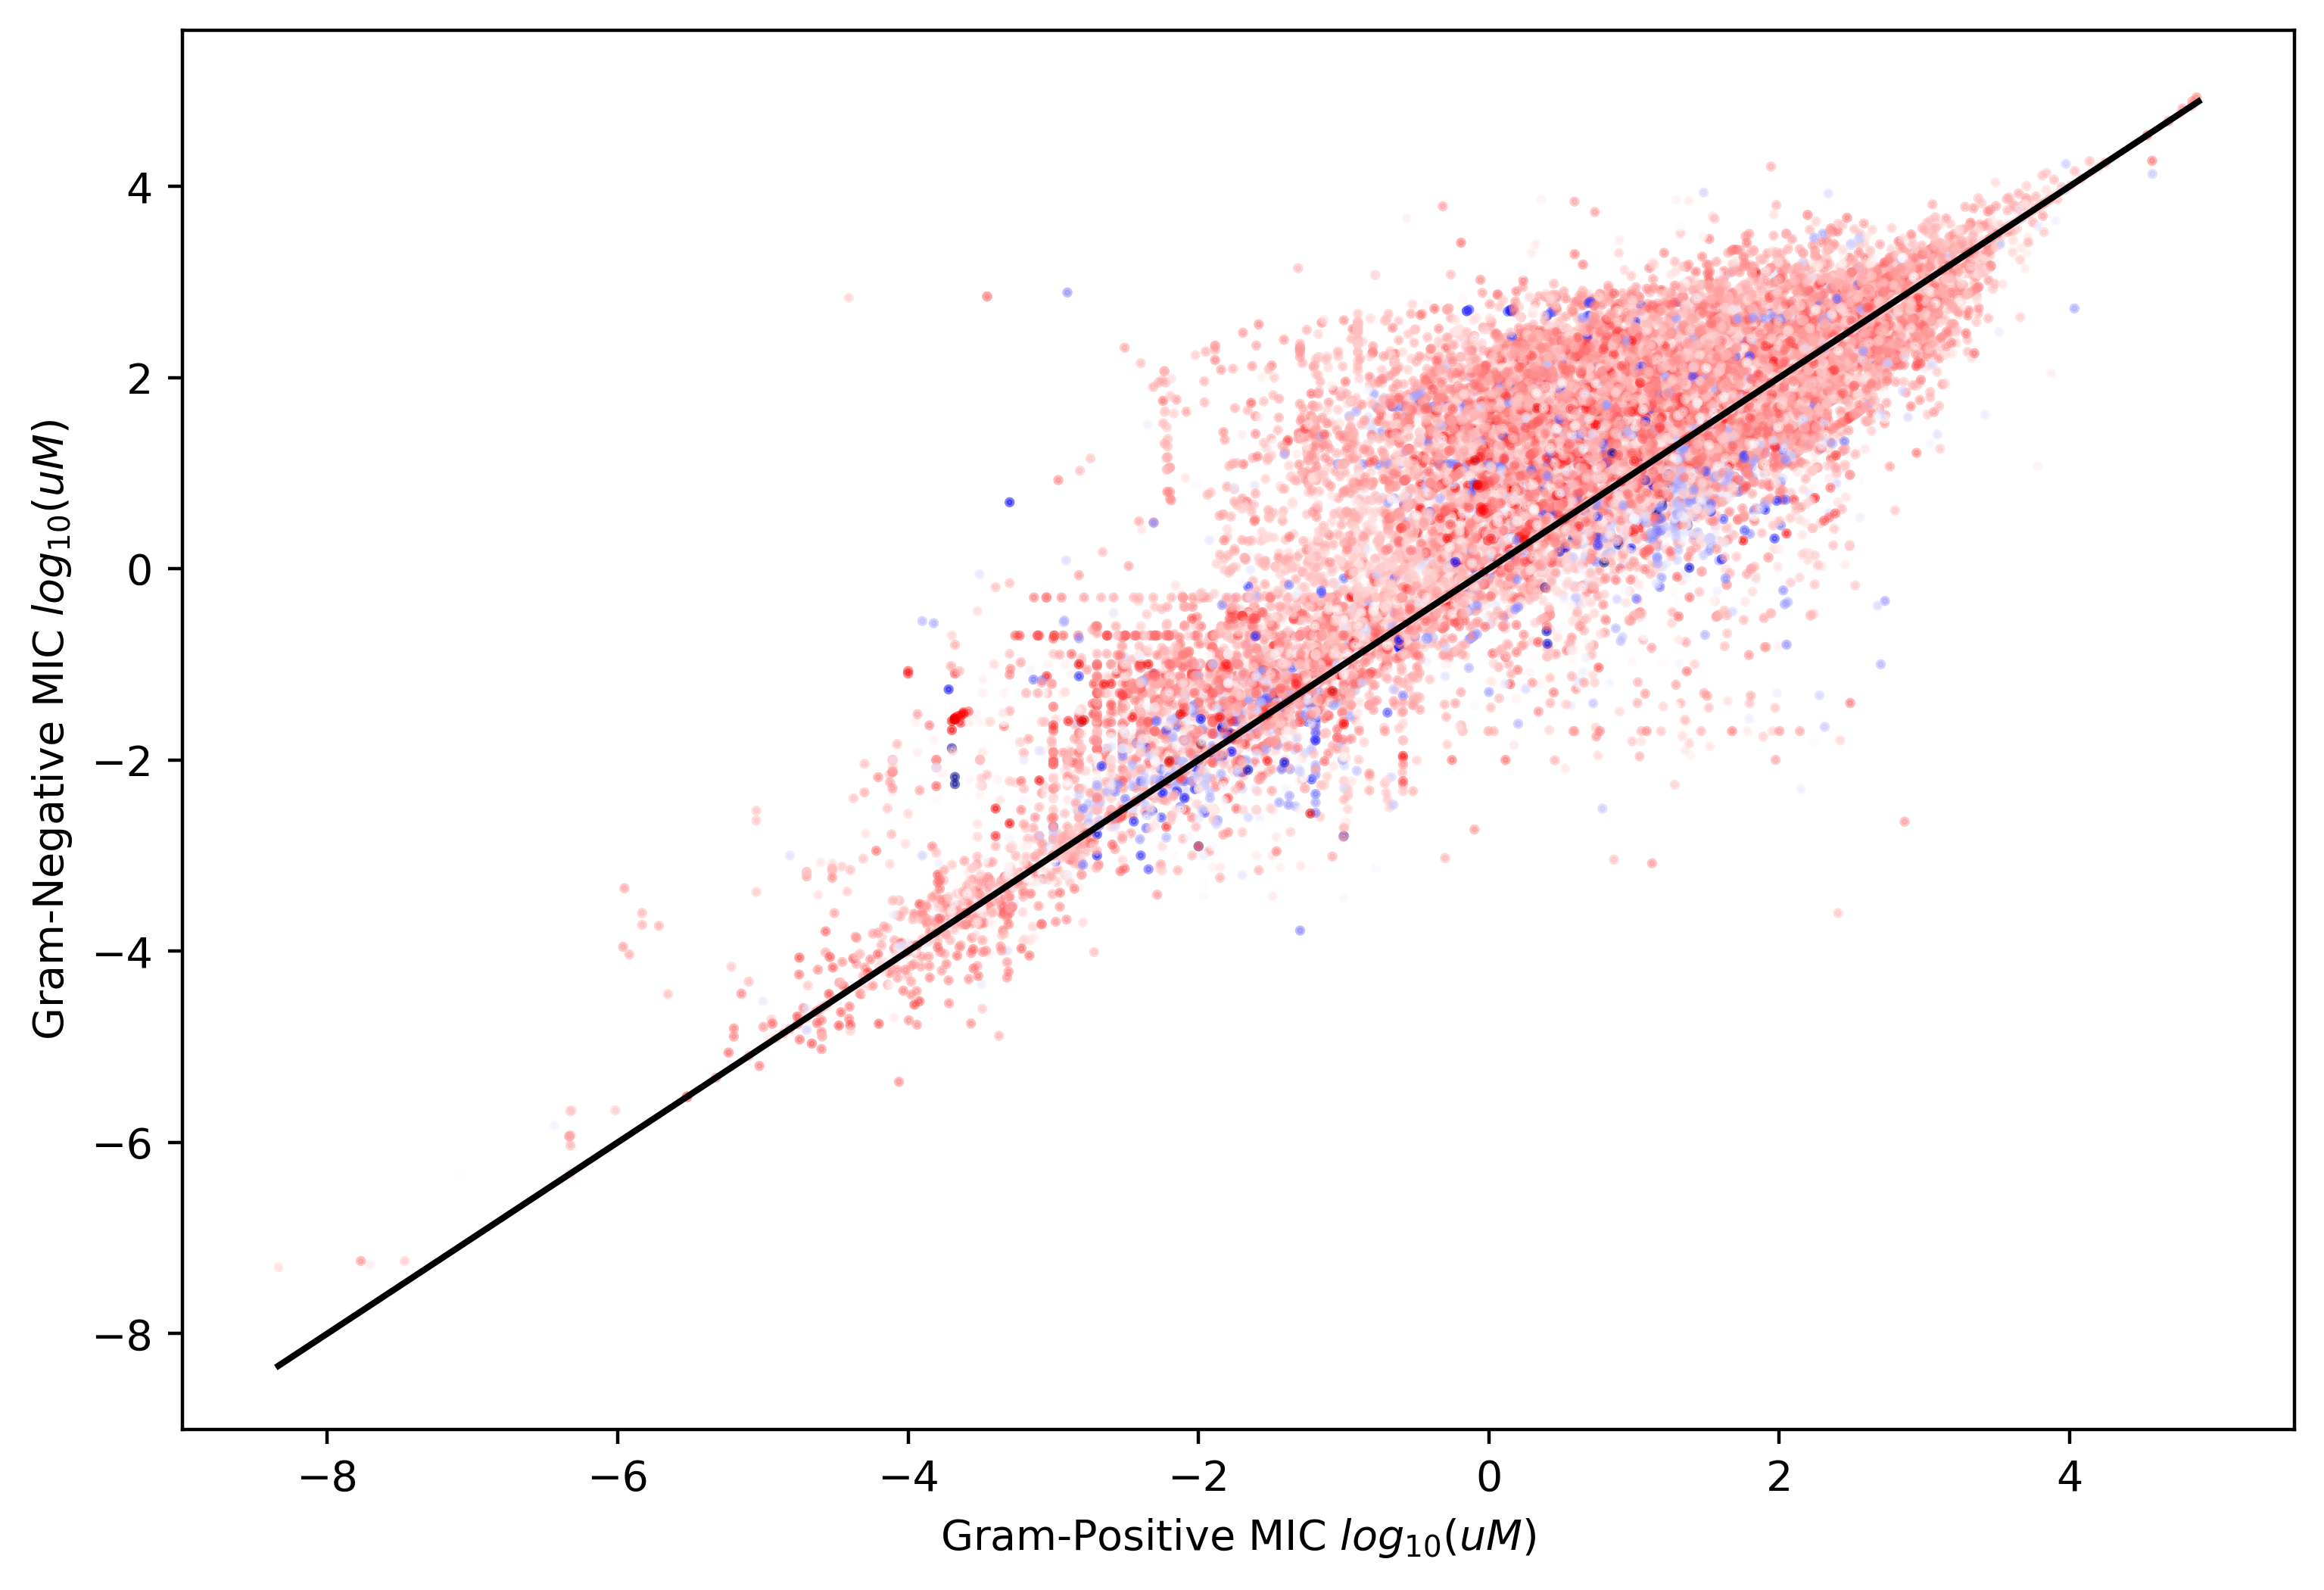

In [57]:
log10_x = np.asarray(np.log10(dual_measured_df['GP Activity']))
log10_y = np.asarray(np.log10(dual_measured_df['GN Activity']))

slope, intercept, r_val, p_val, st_err = stats.linregress(log10_x, log10_y)
xseq = np.linspace(min(log10_x), max(log10_x), num = 10)

fig, ax = plt.subplots(figsize = (9, 6), dpi = 400)
ax.scatter(log10_x, log10_y, s=2, c = dual_measured_df['Log1P'], alpha = 0.5, cmap = 'seismic')

#ax.plot(xseq, slope*xseq+intercept, c = "orange")
ax.plot(xseq, xseq, c = "black")
#fig.colorbar(ax)

ax.set_xlabel("Gram-Positive MIC $log_{10}(uM)$")
ax.set_ylabel("Gram-Negative MIC $log_{10}(uM)$")


#ax.annotate(f'y={slope:.3f}x+{intercept:.3f}\nR$^2$={r_val**2:.3f}\np<0.0001', xy = (-8,2))

#plt.savefig(r'../figures/ChEMBL_Log1p_03045.tiff')

### Histogram of StDevs

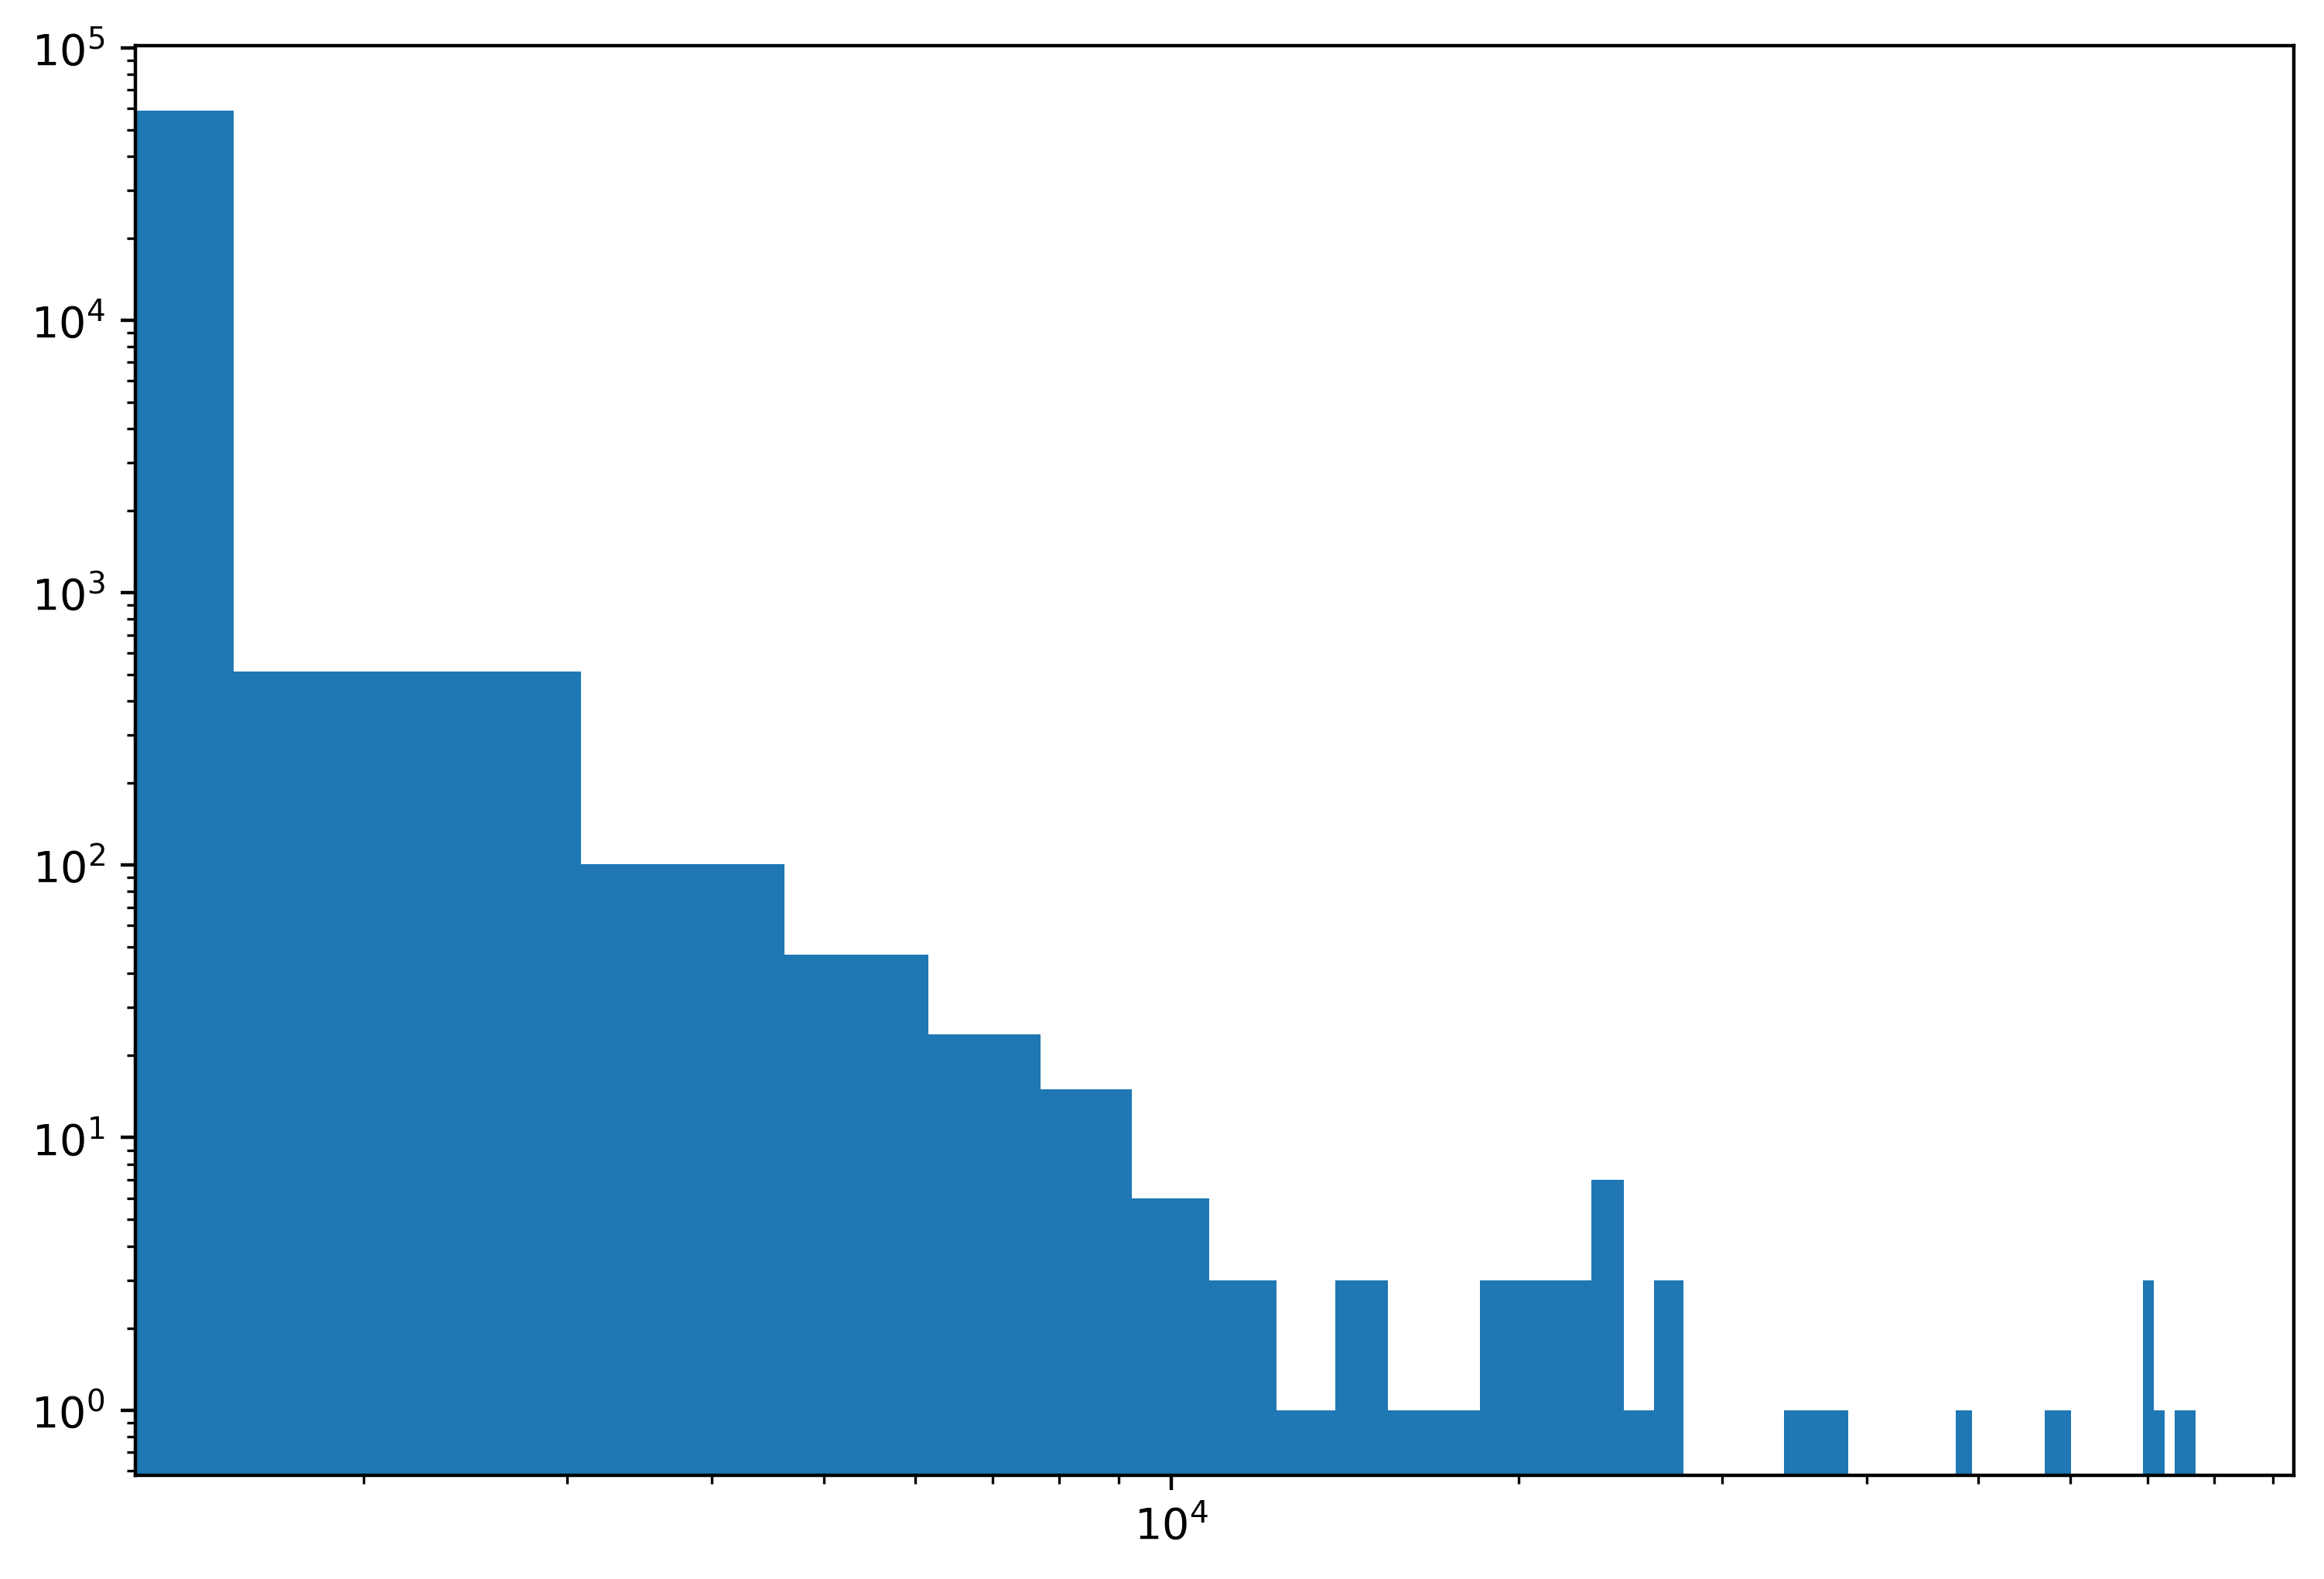

In [404]:
fig2, ax2 = plt.subplots(figsize = (9, 6), dpi = 400)
ax2.hist(sorted_df['GP Activity'], bins = 50)


ax2.set_yscale('log')

#ax2.set_xlabel("Gram-Positive MIC $log_{10}(uM)$")
#ax2.set_ylabel("Gram-Negative MIC $log_{10}(uM)$")


plt.show()

### Percentage of Activites

In [72]:
percent_GP =((sorted_df['GP Activity'] < 100.0).sum())/(sorted_df['GP Activity'].notna()).sum()*100
percent_GN =((sorted_df['GN Activity'] < 100.0).sum())/(sorted_df['GN Activity'].notna()).sum()*100

print(percent_GP, percent_GN)

71.5187323754532 61.427212590254655
